# PyTorch fine-tuning of ResNet50

**Note**: this notebook is part of the [`gperdrizet/CIFAR10`](https://github.com/gperdrizet/CIFAR10) repository and is meant to run in the development container environment specified in that repository. If you are attempting to run in somewhere else you may have to install some dependencies. Start with:

```
pip install image-classification-tools
```

Also install anything else that causes a 'module not found' error the same way.

## Notebook set-up

### Imports

In [ ]:
# Standard library imports
import pickle
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# Package imports
import image_classification_tools.pytorch.data as data_utils
import image_classification_tools.pytorch.evaluation as eval_utils
import image_classification_tools.pytorch.plotting as plots
import image_classification_tools.pytorch.training as training

Using device: cuda


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Paths
MODELS_DIR = Path('../models/pytorch')
RESULTS_DIR = Path('../data/pytorch/performance_results')
DATA_DIR = Path('../data/pytorch/cifar10')

# Make sure directories exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

# CIFAR-10 class names in class order
CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

### Configuration

### Hyperparameters

In [2]:
validation_size = 10000
batch_size = 64
learning_rate = 1e-3
epochs = 100  # Early stopping will halt if validation accuracy stops improving
print_every = 5

## 1. Load and preprocess CIFAR-10 data

### 1.1. Visualize sample images

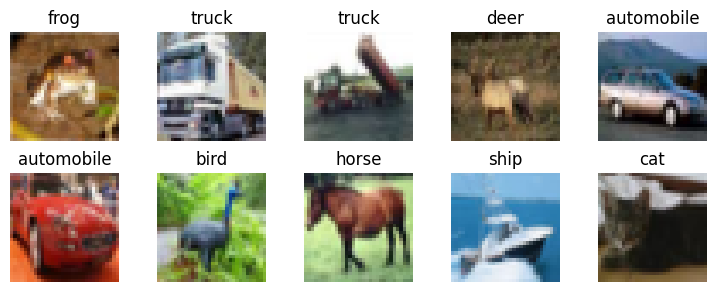

In [ ]:
# Get a sample dataset for visualization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
sample_dataset = datasets.CIFAR10(root=DATA_DIR, transform=transform)
                                    
# Plot first 10 images from the training dataset
fig, axes = plots.plot_sample_images(sample_dataset, CLASS_NAMES)
plt.show()

### 1.2. Define preprocessing transform

In [4]:
# Define basic input transforms (RGB) - no resize needed, we'll adapt the model
# to the CIFAR-10 image size later
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_dataset = data_utils.load_dataset(
    data_source=datasets.CIFAR10,
    transform=transform,
    root=DATA_DIR,
    train=True
)

test_dataset = data_utils.load_dataset(
    data_source=datasets.CIFAR10,
    transform=transform,
    root=DATA_DIR,
    train=False
)

### 1.4. Make training, validation split

In [6]:
train_dataset, val_dataset, test_dataset = data_utils.prepare_splits(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    val_size=validation_size
)

### 1.5. Create dataloaders

In [ ]:
train_loader, val_loader, test_loader = data_utils.create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=batch_size,
    preload_to_memory=True,
    device=DEVICE
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 625
Validation batches: 157
Test batches: 157


## 2. ResNet50

### 2.1. Load model

In [8]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

print('\nModel layers:\n')

for name, module in model.named_modules():
    print(f'Name: {name}, Module Type: {module.__class__.__name__}')


Model layers:

Name: , Module Type: ResNet
Name: conv1, Module Type: Conv2d
Name: bn1, Module Type: BatchNorm2d
Name: relu, Module Type: ReLU
Name: maxpool, Module Type: MaxPool2d
Name: layer1, Module Type: Sequential
Name: layer1.0, Module Type: Bottleneck
Name: layer1.0.conv1, Module Type: Conv2d
Name: layer1.0.bn1, Module Type: BatchNorm2d
Name: layer1.0.conv2, Module Type: Conv2d
Name: layer1.0.bn2, Module Type: BatchNorm2d
Name: layer1.0.conv3, Module Type: Conv2d
Name: layer1.0.bn3, Module Type: BatchNorm2d
Name: layer1.0.relu, Module Type: ReLU
Name: layer1.0.downsample, Module Type: Sequential
Name: layer1.0.downsample.0, Module Type: Conv2d
Name: layer1.0.downsample.1, Module Type: BatchNorm2d
Name: layer1.1, Module Type: Bottleneck
Name: layer1.1.conv1, Module Type: Conv2d
Name: layer1.1.bn1, Module Type: BatchNorm2d
Name: layer1.1.conv2, Module Type: Conv2d
Name: layer1.1.bn2, Module Type: BatchNorm2d
Name: layer1.1.conv3, Module Type: Conv2d
Name: layer1.1.bn3, Module Type

### 2.2. Replace input

The the first four layers in ResNet50 are a 7×7 convolution with a stride of 2 + max pooling with stride 2. This aggressively downsamples by 4x and was designed for 224×224 images. For 32×32 CIFAR images we can replace it with a 3×3, stride 1 convolution and remove the maxpool.

In [9]:
# Replace the stem (conv1 + maxpool) to work with 32x32 CIFAR images
# Original stem: 7x7 conv stride 2 + 3x3 maxpool stride 2 = 4x downsampling
# New stem: 3x3 conv stride 1, no maxpool = preserves spatial resolution
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model.maxpool = nn.Identity()

### 2.3. Replace output layer

In [10]:
# Check the number of input/output features to the final layer
num_inputs = model.fc.in_features
num_outputs = model.fc.out_features
print(f'Original final layer input features: {num_inputs}')
print(f'Original final layer output: {num_outputs} classes')

Original final layer input features: 2048
Original final layer output: 1000 classes


In [ ]:
# Replace the final layer with dropout + linear
# Dropout helps prevent overfitting during fine-tuning
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_inputs, len(CLASS_NAMES))
)

new_num_outputs = len(CLASS_NAMES)
print(f'New final layer: Dropout(0.5) -> Linear({num_inputs}, {new_num_outputs})')

New final layer: Dropout(0.5) -> Linear(2048, 10)


### 2.4. Freeze layers

We freeze everything except:
- The new stem (conv1) - since it's a new untrained layer
- Layer 4 - the last set of 3 blocks of 3 convolutional layers
- The fully connected output layer (fc)

In [12]:
for name, param in model.named_parameters():

    # Freeze everything except conv1, layer4, and fc
    if 'conv1' not in name and 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

Total parameters: 23,520,906
Trainable parameters: 16,695,050


## 3. Fine-tuning

In [13]:
# Define criterion and optimizer for training
# Weight decay (L2 regularization) helps prevent overfitting
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [ ]:
%%time

# Do the run, moving the model to the selected device
# Early stopping will halt training when validation accuracy stops improving
history = training.train_model(
    model=model.to(DEVICE), 
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    lazy_loading=False,
    device=DEVICE,
    epochs=epochs,
    print_every=print_every,
    enable_early_stopping=True,
    early_stopping_patience=3
)

print()

Epoch   1/100 - loss: 0.7090 - acc: 75.38% - val_loss: 0.3274 - val_acc: 89.19%
Epoch   5/100 - loss: 0.1175 - acc: 96.03% - val_loss: 0.2772 - val_acc: 91.41%
Epoch  10/100 - loss: 0.0758 - acc: 97.46% - val_loss: 0.2932 - val_acc: 91.42%

Early stopping at epoch 11
Best val_loss: 0.2366 at epoch 8
Restored best model weights

CPU times: user 13min 34s, sys: 498 ms, total: 13min 35s
Wall time: 13min 31s


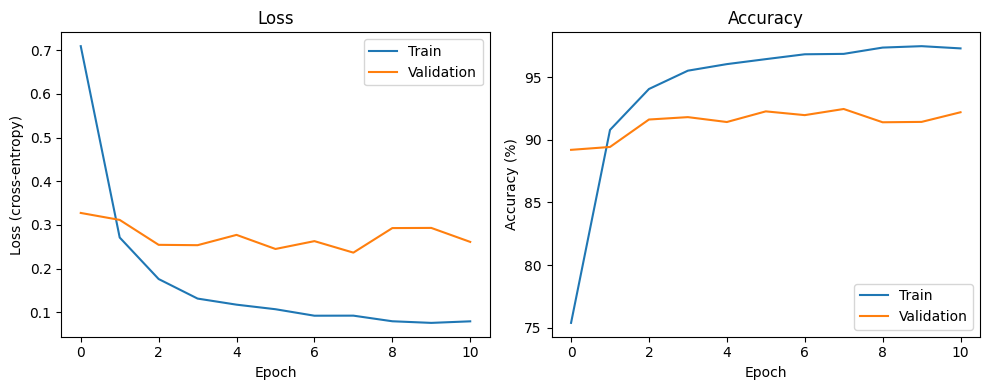

In [15]:
fig, axes = plots.plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [16]:
test_accuracy, predictions, true_labels = eval_utils.evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 92.50%


### 3.2. Per-class accuracy

In [ ]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in CLASS_NAMES}
class_total = {name: 0 for name in CLASS_NAMES}

for pred, true in zip(predictions, true_labels):

    class_name = CLASS_NAMES[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in CLASS_NAMES:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 93.80%
automobile  : 97.40%
bird        : 88.50%
cat         : 83.40%
deer        : 95.30%
dog         : 88.60%
frog        : 97.60%
horse       : 93.80%
ship        : 94.20%
truck       : 92.40%


### 3.3. Confusion matrix

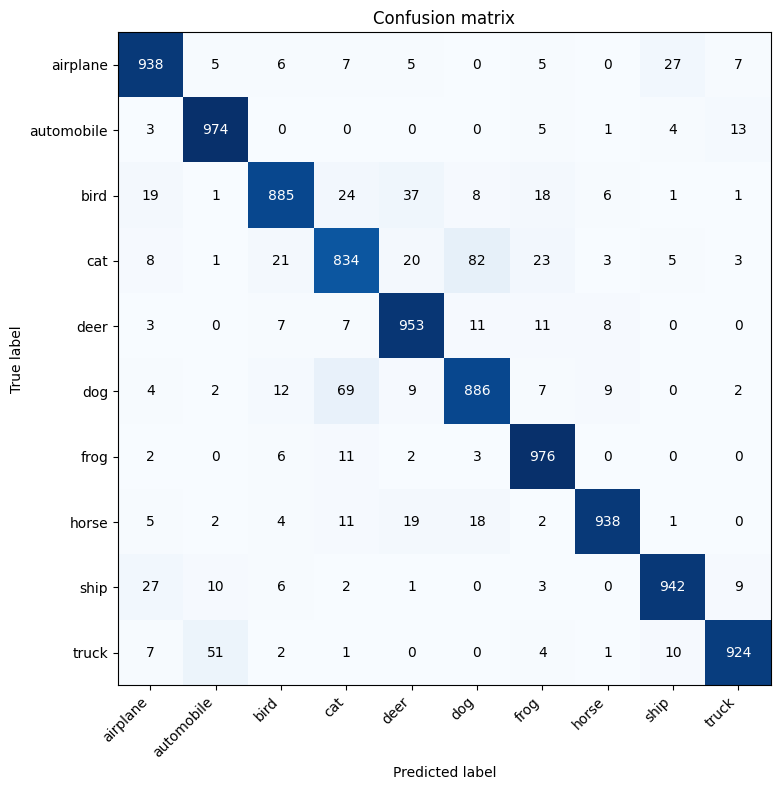

In [ ]:
fig, ax = plots.plot_confusion_matrix(true_labels, predictions, CLASS_NAMES)
plt.show()

### 3.4. Predicted class probability distributions

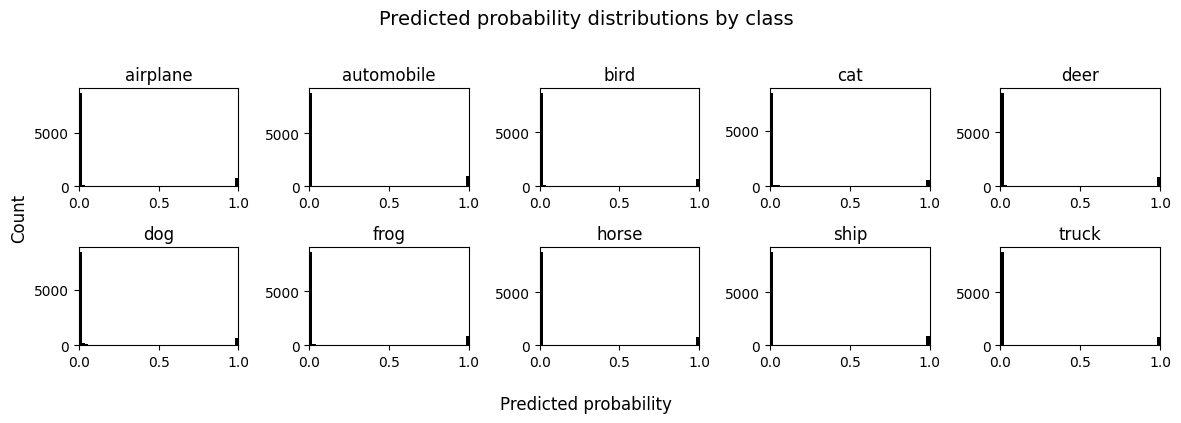

In [ ]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plots.plot_class_probability_distributions(all_probs, CLASS_NAMES)
plt.show()

### 3.5. Evaluation curves

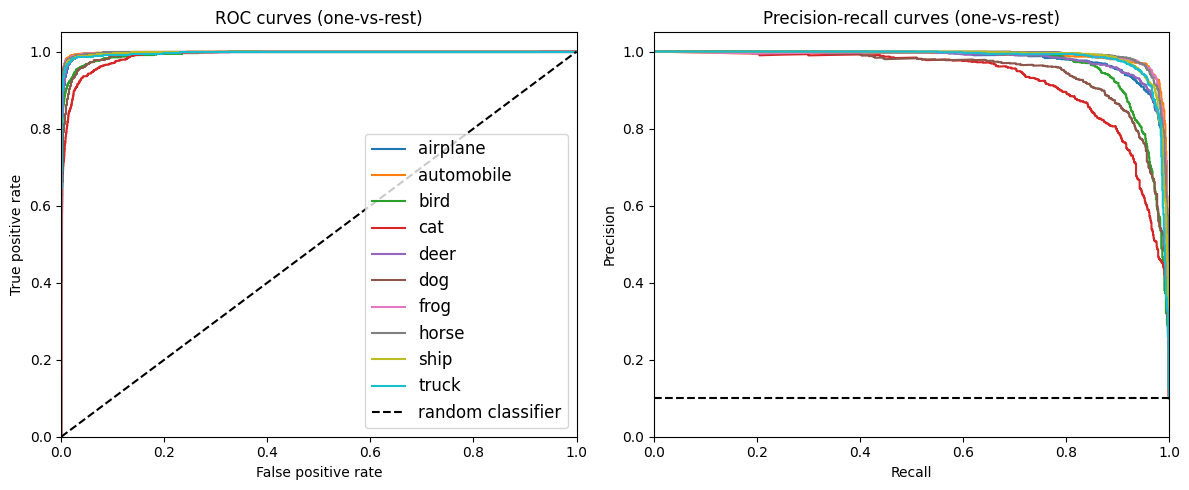

In [ ]:
fig, (ax1, ax2) = plots.plot_evaluation_curves(true_labels, all_probs, CLASS_NAMES)
plt.show()

## 4. Save model

In [ ]:
# Save trained model
model_path = MODELS_DIR / 'resnet50.pth'
torch.save(model, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/resnet50.pth
Test accuracy: 92.50%


## 5. Save test results for comparison

In [ ]:
# Save results path
results_path = RESULTS_DIR / 'resnet50_results.pkl'

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create results dictionary
results_dict = {
    'true_labels': true_labels,
    'predictions': predictions,
    'all_probs': all_probs,
    'test_accuracy': test_accuracy,
    'total_params': total_params,
    'trainable_params': trainable_params
}

# Save results
with open(results_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f'Test results saved to: {results_path}')

print(f'  - Test accuracy: {test_accuracy:.2f}%')
print(f'  - Trainable parameters: {trainable_params:,}')
print(f'  - Total parameters: {total_params:,}')


Test results saved to: ../data/pytorch/performance_results/resnet50_results.pkl
  - Test accuracy: 92.50%
  - Trainable parameters: 16,695,050
  - Total parameters: 23,520,906
